# Advanced Regression Techniques: House Prices (Kaggle Competition)
## Arvindh Arul


## Importing the required packages 

In [51]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score,cross_val_predict,StratifiedKFold
#from sklearn.cross_validation import GridSearchCV
from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingRegressor as xgb 
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from scipy import stats 
import seaborn as sns

%matplotlib inline

## Loading the datasets 
The train and test datasets are loaded from https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [52]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv") 
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Missing values 
 
Some of the columns in the training dataset seem to have a lot of missing values. It would be sensible to drop these columns if the number of missing values comprises more than some threshold (say 15%) of the data in the column. 

In [53]:
frac = train.shape[0]*0.9 # number of non NA values we are satisfied with in each column . Lets say we need at least 90% non-NA values (columns with more than these will be dropped)
percent_missing = (100*(train.isnull().sum())/train.shape[0]).round(1) 
percent_missing.sort_values(ascending = False).head(20)


PoolQC          99.5
MiscFeature     96.3
Alley           93.8
Fence           80.8
FireplaceQu     47.3
LotFrontage     17.7
GarageCond       5.5
GarageType       5.5
GarageYrBlt      5.5
GarageFinish     5.5
GarageQual       5.5
BsmtExposure     2.6
BsmtFinType2     2.6
BsmtFinType1     2.5
BsmtCond         2.5
BsmtQual         2.5
MasVnrArea       0.5
MasVnrType       0.5
Electrical       0.1
Utilities        0.0
dtype: float64

In [54]:
frac

1314.0

We can see certain variables 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu' with a high proportion of missing values. Variables concerning Garage and Basmement also account for less than 5% missing values. We need to inspect these categorical variables in more detail to determine if these are indeed 'missing values' or labelled NaN because of an absence of a feature eg. garage, fence, alley etc.For the latter case, we need to set the NaN values to 'None'.

Grouping all categorical variables with NaN values. Variables belonging to similar categories have been grouped together for comparison e.g. Basement, MasVnr, Garage etc. Non-categorical variables have also been included (e.g Pool Area, MasVnrArea) if they help in deciding if the NaN in categorical variable of the same category need to be set to None or dropped. If PoolQC is NaN and PoolArea is 0 it is highly likely that the NaN means an absence of a pool and should be said to None. 

In [55]:

train_cat = train[['BsmtFinType1','BsmtFinType2','BsmtCond', 'BsmtQual','Electrical','MasVnrArea','MasVnrType', 'GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt','MiscFeature','Fence','PoolQC','PoolArea','Alley','FireplaceQu']]

train_cat.head(5)

,BsmtFinType1,BsmtFinType2,BsmtCond,BsmtQual,Electrical,MasVnrArea,MasVnrType,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,MiscFeature,Fence,PoolQC,PoolArea,Alley,FireplaceQu
0,GLQ,Unf,TA,Gd,SBrkr,196.0,BrkFace,TA,RFn,TA,Attchd,2003.0,NaN,NaN,NaN,0,NaN,NaN
1,ALQ,Unf,TA,Gd,SBrkr,0.0,None,TA,RFn,TA,Attchd,1976.0,NaN,NaN,NaN,0,NaN,TA
2,GLQ,Unf,TA,Gd,SBrkr,162.0,BrkFace,TA,RFn,TA,Attchd,2001.0,NaN,NaN,NaN,0,NaN,TA
3,ALQ,Unf,Gd,TA,SBrkr,0.0,None,TA,Unf,TA,Detchd,1998.0,NaN,NaN,NaN,0,NaN,Gd
4,GLQ,Unf,TA,Gd,SBrkr,350.0,BrkFace,TA,RFn,TA,Attchd,2000.0,NaN,NaN,NaN,0,NaN,TA


## Categorical Variables 

The table above shows that NaN values of all variables should be set to 'None'.
Garage variables : Where there are NaN values, they occur in all garage variables suggesting absence of garages for those houses 
Pool - PoolQC is set to NaN corresponding to PoolArea of 0, suggesting absence of Pool. This should be set to 'None'
Basement : 
Similarly, NaN values in Alley, Fence, Miscfeatures suggest absence of this feature in the house and should be set to 'None'
In case of the Electrical variable, setting the NaN value to 'None' does not make sense as it is a feature that all houses should have. Since it only accounts for 0.1% of the observations,the corresponding rows will be dropped. 


In [56]:
#train.drop(train['Electrical'][train.Electrical.isnull()].index[0], inplace=True) # dropping the row with the NaN value 
  
Categories = ['BsmtFinType1','BsmtFinType2','BsmtCond', 'BsmtQual','MasVnrType', 'GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt','MiscFeature','FireplaceQu','Fence','PoolQC','Alley']
for cat in Categories:
    train[cat].fillna('None',inplace=True)
        
train[Categories].head(10)
      

,BsmtFinType1,BsmtFinType2,BsmtCond,BsmtQual,MasVnrType,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,MiscFeature,FireplaceQu,Fence,PoolQC,Alley
0,GLQ,Unf,TA,Gd,BrkFace,TA,RFn,TA,Attchd,2003,None,None,None,None,None
1,ALQ,Unf,TA,Gd,None,TA,RFn,TA,Attchd,1976,None,TA,None,None,None
2,GLQ,Unf,TA,Gd,BrkFace,TA,RFn,TA,Attchd,2001,None,TA,None,None,None
3,ALQ,Unf,Gd,TA,None,TA,Unf,TA,Detchd,1998,None,Gd,None,None,None
4,GLQ,Unf,TA,Gd,BrkFace,TA,RFn,TA,Attchd,2000,None,TA,None,None,None
5,GLQ,Unf,TA,Gd,None,TA,Unf,TA,Attchd,1993,Shed,None,MnPrv,None,None
6,GLQ,Unf,TA,Ex,Stone,TA,RFn,TA,Attchd,2004,None,Gd,None,None,None
7,ALQ,BLQ,TA,Gd,Stone,TA,RFn,TA,Attchd,1973,Shed,TA,None,None,None
8,Unf,Unf,TA,TA,None,TA,Unf,Fa,Detchd,1931,None,TA,None,None,None
9,GLQ,Unf,TA,TA,None,TA,RFn,Gd,Attchd,1939,None,TA,None,None,None


We now need to impute missing values for the non-categorical variable using the mean of each univariate distribution. The catgeorical variables will then be one hot encoded to covert into numbers for furthr analysis (correlation/ modelling). 

In [57]:
train.fillna(train.mean(), inplace=True)

In [60]:
 # converting categorical variables to dummy variables encoded with 0,1....
train= pd.get_dummies(data=train,drop_first=True)
train.head(10)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.000000,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.000000,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.000000,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.000000,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.000000,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,1,0
5,6,50,85.000000,14115,5,5,1993,1995,0.0,732,...,0,0,0,0,1,0,0,0,1,0
6,7,20,75.000000,10084,8,5,2004,2005,186.0,1369,...,0,0,0,0,1,0,0,0,1,0
7,8,60,70.049958,10382,7,6,1973,1973,240.0,859,...,0,0,0,0,1,0,0,0,1,0
8,9,50,51.000000,6120,7,5,1931,1950,0.0,0,...,0,0,0,0,1,0,0,0,0,0
9,10,190,50.000000,7420,5,6,1939,1950,0.0,851,...,0,0,0,0,1,0,0,0,1,0


## Feature Engineering 
Now we will determine which features are important for subsequent analysis and must be inlcuded. We will first calculate the correlation of all variables with sales price and filter out variables which correlate less than abs 0.5.Using these filtered features we will then create a correltion matrix to determine which of these features display multicollinerity with other dependent variables. Similar features can either be merged into one compound feature or just one of th features included in subsequent analysis

In [61]:
corr1 = train.corr()['SalePrice'] #array of correlation values for each variable vs. SalePrice 
corr =corr1[np.abs(corr1) > 0.5]  # just return correlation values greater than abs(0.5)
corr = pd.DataFrame(data=corr,columns= ['SalePrice'])
corr = corr.drop_duplicates().sort_values('SalePrice',ascending =False)
corr

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


We can see that the Overall Quality and Garage Living area showed strong positive correlation with sale price. Other variables which showed > 50% correlation with sales price were: 

OverallQual     
GrLivArea        
GarageCars       
GarageArea       
TotalBsmtSF      
1stFlrSF         
FullBath         
TotRmsAbvGrd     
YearBuilt    
KitchenQual_TA
ExternalQual_TA

The KitchenQual_TA and ExternalQual_TA dummy variables which correspond to normal/average quality of kitchnen and exterior showed some negative correlation (< -0.6%) with sales price which is what one would expect i.e. as house price increases the quality of kitchen and exterion should become 'less average' and vice versa  
We will now plot a new correlation matrix with these filtered variables 

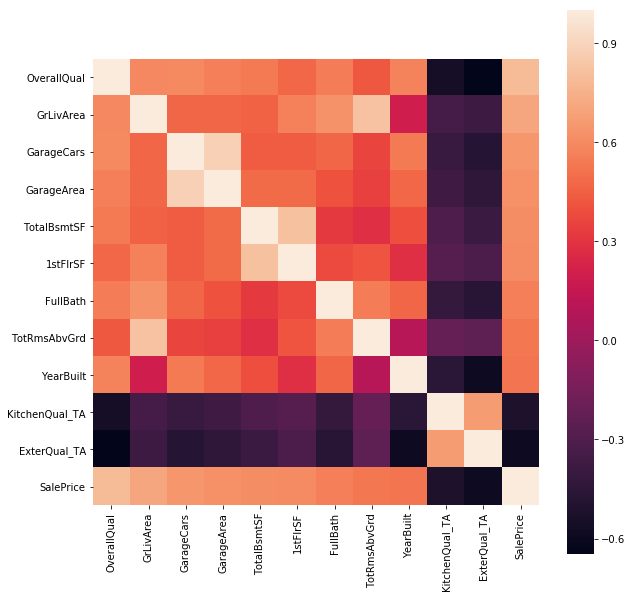

In [62]:
corr_var = ['OverallQual','GrLivArea', 'GarageCars', 'GarageArea','TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt','KitchenQual_TA', 'ExterQual_TA','SalePrice']
train = train[corr_var]
train
corr_matrix = train.corr()
f,ax = plt.subplots(figsize =(10,10))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, vmax=1,square=True)


We find similar variables correlating with each other e.g. GarageCars and GarageArea, 1stFlrSF and TotalBsmtSF, GLivArea and TotRmsAbvGrd, Kitchen/external_Qual shows some correlation with the overall quality (compound variable) and year built. So we can drop one of the variables which show multicollinearity. Here GarageArea, TotalRmsAbvGrd,  1stFlrSF, KitchenQual, ExternalQual were dropped because they correlated less with sales price compare to the other variables they correlated with. 

In [63]:
labels_to_drop = ['GarageArea','TotRmsAbvGrd','1stFlrSF', 'KitchenQual_TA','ExterQual_TA']
train = train.drop(labels_to_drop, axis =1)
train.head(10) 

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,SalePrice
0,7,1710,2,856,2,2003,208500
1,6,1262,2,1262,2,1976,181500
2,7,1786,2,920,2,2001,223500
3,7,1717,3,756,1,1915,140000
4,8,2198,3,1145,2,2000,250000
5,5,1362,2,796,1,1993,143000
6,8,1694,2,1686,2,2004,307000
7,7,2090,2,1107,2,1973,200000
8,7,1774,2,952,2,1931,129900
9,5,1077,1,991,1,1939,118000


We have now got a dataframe with the SalePrice (output variable) and 6 predictor variables. Now we need to process the data further for outliers 

## Outlier detection 

Most commonly used method to detect outliers is visualization like Box-plot, Histogram, Scatter Plot. Here I will use scatter plots for the continous variables and boxplots for the categorical variables. We can use certain rules of thumb like:
Any value, which is beyond the range of -1.5 x IQR to 1.5 x IQR
Data points, three or more standard deviation away from mean 
If a few isolated points lie outside the general trend line, then they can be deleted. 

Text(0.5, 1.0, 'Sale Price vs Garage Cars')

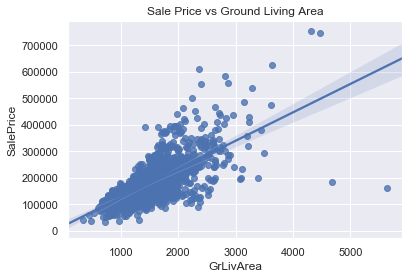

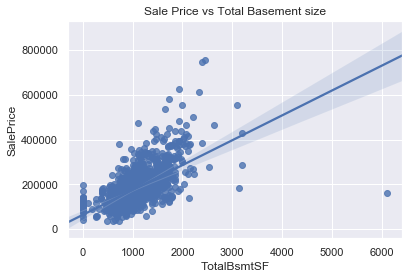

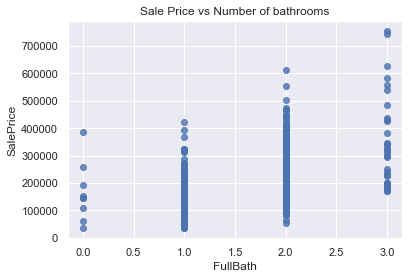

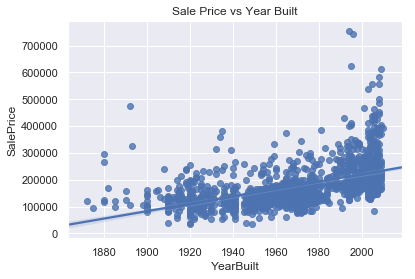

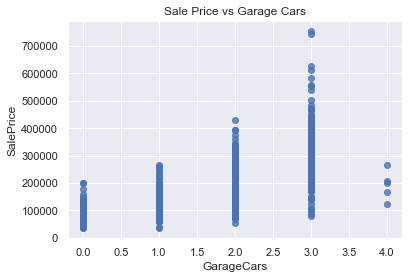

In [64]:
plt.figure(1)
sns.set(color_codes=True)
ax = sns.regplot(x="GrLivArea", y="SalePrice", data=train)
plt.title('Sale Price vs Ground Living Area')

plt.figure(2)
sns.set(color_codes=True)
ax = sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train)
plt.title('Sale Price vs Total Basement size')

plt.figure(3)
sns.set(color_codes=True)
ax = sns.regplot(x="FullBath", y="SalePrice", data=train, fit_reg = False)
plt.title('Sale Price vs Number of bathrooms')

plt.figure(4)
sns.set(color_codes=True)
ax = sns.regplot(x="YearBuilt", y="SalePrice", data=train)
plt.title('Sale Price vs Year Built')


plt.figure(5)
sns.set(color_codes=True)
ax = sns.regplot(x="GarageCars", y="SalePrice", data=train, fit_reg = False)
plt.title('Sale Price vs Garage Cars')

Four outliers in the graphs above will be dropped. These corresponding to ground living area > 4500 and sales price between 7000 and 8000 in Year Built graph.The isolated TotalBsmtSF point > 6000 is also included as part of these outliers which will be removed.


In [65]:
#train.sort_values(by = 'GrLivArea', ascending = False)[:10]
#train.sort_values(by = 'SalePrice', ascending = False)[:10]
train =train.drop(train[train.GrLivArea == 5642].index)
train =train.drop(train[train.GrLivArea == 4476].index)
train =train.drop(train[train.SalePrice == 755000].index)
train =train.drop(train[train.SalePrice == 745000].index)


## Normality and linearity

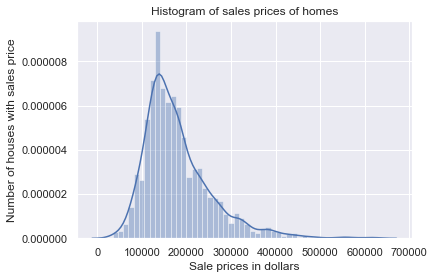

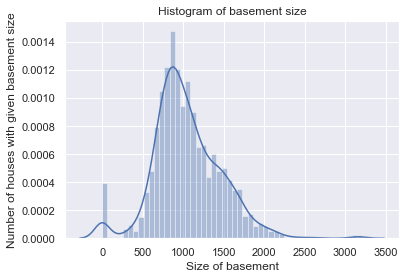

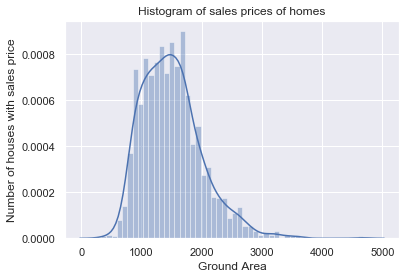

In [66]:
plt.figure(1)
sns.distplot(train['SalePrice'], 50)
plt.xlabel("Sale prices in dollars")
plt.ylabel("Number of houses with sales price") 
plt.title("Histogram of sales prices of homes")
plt.grid(True) 
plt.show()


plt.figure(2)
sns.distplot(train['TotalBsmtSF'], 50)
plt.xlabel("Size of basement")
plt.ylabel("Number of houses with given basement size") 
plt.title("Histogram of basement size")
plt.grid(True) 
plt.show()

plt.figure(3)
sns.distplot(train['GrLivArea'], 50)
plt.xlabel("Ground Area")
plt.ylabel("Number of houses with sales price") 
plt.title("Histogram of sales prices of homes")
plt.grid(True) 
plt.show()



### Standardisation of datasets 

Since univariate distributions above are skewed, the data needs to be standardised so individual features are more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. One way of doing this is by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.
Alternatively, a log transofrmation can be applied althought it can’t be applied to zero or negative values. Our second histogram above shows some zero values for basement size which would not be suitable for log transformation unless they are removed. 

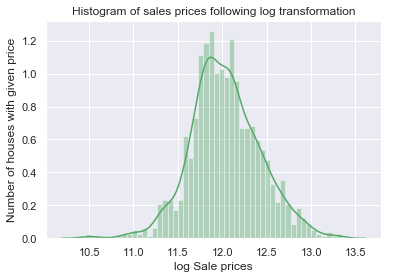

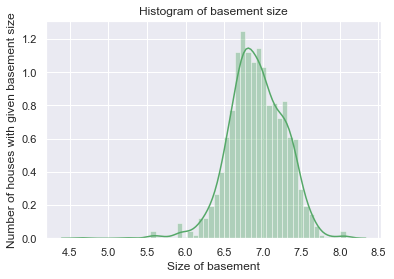

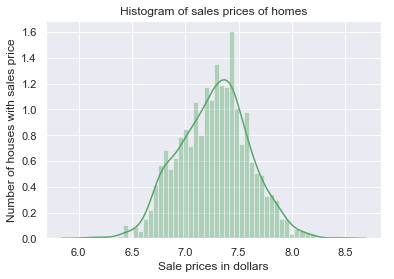

In [67]:
# Removing zero values in TotalBsmtSF to perform log transormation afterwards 
train_new = train.drop(train[train['TotalBsmtSF']==0].index, axis =0)

train_new.loc[:,['SalePrice','TotalBsmtSF','GrLivArea','YearBuilt']] = np.log(train_new[['SalePrice','TotalBsmtSF','GrLivArea','YearBuilt']])
plt.figure(1)
sns.distplot(train_new['SalePrice'], 50, color = "g")
plt.xlabel("log Sale prices")
plt.ylabel("Number of houses with given price") 
plt.title("Histogram of sales prices following log transformation")
plt.grid(True) 
plt.show()

plt.figure(2)
sns.distplot(train_new['TotalBsmtSF'], 50, color ="g")
plt.xlabel("Size of basement")
plt.ylabel("Number of houses with given basement size") 
plt.title("Histogram of basement size")
plt.grid(True) 
plt.show()

plt.figure(3)
sns.distplot(train_new['GrLivArea'], 50, color ="g")
plt.xlabel("Sale prices in dollars")
plt.ylabel("Number of houses with sales price") 
plt.title("Histogram of sales prices of homes")
plt.grid(True) 
plt.show()


The distrbutions are now centred and more normally distributed and less skewed. 

### Scatter plots after log transformation 

Text(0.5, 1.0, 'Log Sale Price vs Log Total Basement size')

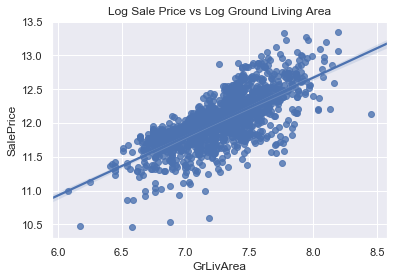

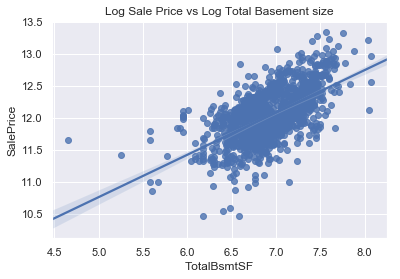

In [68]:
plt.figure()
sns.set(color_codes=True)
ax = sns.regplot(x="GrLivArea", y="SalePrice", data=train_new)
plt.title('Log Sale Price vs Log Ground Living Area')

plt.figure()
sns.set(color_codes=True)
ax = sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train_new)
plt.title('Log Sale Price vs Log Total Basement size')



We can see that the dense clutter in the scatter plots are now shifted towards the centre following log transormation. As a result, the data will exhibit less less heteroskedasticity (absence of the conical shape like in the previous plots).

## Cleaning test data 
Lets apply all the pre-processing tasks above to the test data. We can directly keep the same features in the test set as we did in the training set. We can then check if we need to replace any missing values. We will not need to create any dummy variables as all categorical variables were removed after correlation analysis. 

In [69]:
var = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath','YearBuilt']

test_id = test[['Id']] # store id data n separate single column data frame 
test = test[var]
test.head(10)
test.shape[0] -((test[test.notnull()].count())) # number of missing values. It looks like Garage Cars and TotalBsmtSF have one
# Probably the same row. We can either drop this observation or impute it.

test['GarageCars'] = test['GarageCars'].fillna((test['GarageCars'].mean()))
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna((test['TotalBsmtSF'].mean()))

# taking log transform 
test[['TotalBsmtSF']] = test[['TotalBsmtSF']].replace(0,1)

test.loc[:,['TotalBsmtSF','GrLivArea', 'YearBuilt']] = np.log(test[['TotalBsmtSF','GrLivArea','YearBuilt']])



Our test data is now ready for testing our model on once we have trained it on the training dataset 

## Modelling 

We will try a number of models to solve the regression problem. These include the following:

Ridge regression: addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares

Lasso Regression:  estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. 

Support Vector Machines: The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. In the case of regression, a margin of tolerance (epsilon) is set. The goal is to find an optimal hyperplane that deviates from yn by a value no greater than epsilon for each training point x, and at the same time is as flat as possible.The free parameters in the model are C and epsilon.

Gradient Boosting (GB) Regressor: GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.



In [70]:
train_y = train_new['SalePrice']  #saving the output variable as a seperate dataset 
train_x = train_new.drop('SalePrice', axis =1) # dropping output variable from train dataset 
train_x.head(10)

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,7,7.444249,2,6.752270,2,7.602401
1,6,7.140453,2,7.140453,2,7.588830
2,7,7.487734,2,6.824374,2,7.601402
3,7,7.448334,3,6.628041,1,7.557473
4,8,7.695303,3,7.043160,2,7.600902
5,5,7.216709,2,6.679599,1,7.597396
6,8,7.434848,2,7.430114,2,7.602900
7,7,7.644919,2,7.009409,2,7.587311
8,7,7.480992,2,6.858565,2,7.565793
9,5,6.981935,1,6.898715,1,7.569928


In [77]:

## Ridge Regression with built in cross validation ####
# by default it performs Generalized Cross-Validation, which is a form of efficient Leave-One-Out cross-validation.

clf_Ridge = linear_model.Ridge(fit_intercept=True, normalize=True, alpha = 0.01) 
clf_Ridge.fit(train_x, train_y)  
clf_Ridge_score = cross_val_score(clf_Ridge,train_x, train_y, cv = 10, scoring = 'r2')

### Support Vecotr Regression #####
X_scaler = preprocessing.StandardScaler()
train_x = X_scaler.fit_transform(train_x)
clf_SVR = svm.SVR(kernel='rbf', gamma='auto',C = 1,epsilon = 0.1)
clf_SVR.fit(train_x, train_y)
clf_SVR_score = cross_val_score(clf_SVR, train_x, train_y, cv = 10, scoring='r2') 

#### LassoCV######

clf_lasso = linear_model.Lasso(alpha = 0.01)
clf_lasso.fit(train_x, train_y)
clf_lasso_score = cross_val_score(clf_lasso, train_x, train_y, cv = 10, scoring='r2') 

### Gradient Boosting Regressor ##

clf_xgb = xgb(learning_rate=0.01, n_estimators=500, max_depth=3, subsample= 0.5)
clf_xgb.fit(train_x, train_y)
clf_xgb_score = cross_val_score(clf_xgb, train_x, train_y, cv = 10, scoring='r2') 

 #R squared coefficients for all the models after training 

print ("")
print("The R2 score using for Ridge is %f" % (clf_Ridge_score.mean()))
print("The R2 score for Lasso is %f" % (clf_lasso_score.mean())) 
print("The R2 score for SVR is %f" % (clf_SVR_score.mean())) 
print("The R2 score for Gradient Boosting Regression is %f" % (clf_xgb_score.mean())) 

test_x = X_scaler.fit_transform(test)
predict = pd.DataFrame(np.exp(clf_xgb.predict(test_x)), columns= ['SalePrice'])    # Predictions on the test set


The R2 score using for Ridge is 0.825067
The R2 score for Lasso is 0.823919
The R2 score for SVR is 0.826482
The R2 score for Gradient Boosting Regression is 0.833073


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


xgb gave the highest score and was chosen for prediction on the test set. SVR had the next best score. More work needs to be done on the model tuning to increase R2 score and also exploring other models such as Random Forest and neural networks using Keras with Theano backend.
Note that I have manually tuned the parameters in this case as I was having problems importing the model_selection library and using the GridSearchCV method which would have been ideal for hyperparameter tuning. 

### Saving the predictions as csv file 

In [78]:
submission = pd.concat([test_id, predict],axis =1)
submission.to_csv("submission.csv",header = True, index =False)